<a href="https://colab.research.google.com/github/jeffheaton/app_deep_learning/blob/main/t81_558_class_05_3_vision_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 6: Convolutional Neural Networks (CNN) for Computer Vision**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 5 Material

- Part 5.1: Image Processing in Python [[Video]](https://www.youtube.com/watch?v=Sob7VDb4xh8&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_05_1_python_images.ipynb)
- Part 5.2: Using Convolutional Neural Networks [[Video]](https://www.youtube.com/watch?v=jL0_lOpEwSk&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_05_2_cnn.ipynb)
- **Part 5.3: Using Pretrained Neural Networks** [[Video]](https://www.youtube.com/watch?v=W2T-dfiHYSo&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_05_3_vision_transfer.ipynb)
- Part 5.4: Looking at Generators and Image Augmentation [[Video]](https://www.youtube.com/watch?v=20JoEmQb810&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_05_4_generators.ipynb)
- Part 5.5: Recognizing Multiple Images with YOLOv5 [[Video]](https://www.youtube.com/watch?v=7Uu1n9Tp0Mk&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_05_5_yolo.ipynb)

# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [1]:
# Detect Colab if present
try:
    from google.colab import drive
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: not using Google CoLab
Using device: mps


# Part 5.3: Transfer Learning for Computer Vision

In the vast and intricate landscape of deep learning, getting started can often feel like a monumental task. Fortunately, with PyTorch's **torchvision.models**, one need not reinvent the wheel. This submodule provides a rich library of prebuilt and pretrained neural network models, streamlining the process for developers and researchers alike. While these models can be deployed "out of the box" for quick tasks, they can also be fine-tuned foundational structures for specific applications, offering versatility for a broad spectrum of tasks. Especially in the realm of image processing, torchvision.models showcases an impressive lineup – from the classic convolutional architectures like AlexNet and VGG to more contemporary structures such as ResNets, DenseNets, and MobileNets. In this section, our focus will primarily revolve around these image-based models. To elucidate the process, we will delve deep into a hands-on example that harnesses the prowess of the models.resnet50 to craft a state-of-the-art image classifier.

We will begin by using the ResNet50 prebuilt neural network in its entirety. MobileNet will be loaded and allowed to classify simple images. We can already classify 1,000 images through this technique without ever having trained the network.

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3

# Load pre-trained ResNet model and set to evaluation mode
model = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1').to(device)

Before we dive into the mechanics of using the model, it's imperative to establish an image preprocessing pipeline. A preprocessing pipeline ensures that images fed into the neural network are in the optimal format, size, and normalization for the chosen model. Here's a breakdown of what our preprocessing pipeline entails:

* **Resize(256)** This function resizes the shortest edge of the image to 256 pixels, maintaining the aspect ratio of the original image. The purpose is to standardize the image size while preserving its content.

* **CenterCrop(IMAGE_WIDTH)** After resizing, the image might not be of a uniform size for a neural network. By using CenterCrop, we extract the center part of the image with a width and height equal to IMAGE_WIDTH. This step ensures that all processed images will be of a consistent size, suitable for our neural network.

* **ToTensor()** Neural networks in PyTorch expect input data to be in the form of tensors. ToTensor() takes the PIL image (or a NumPy array) and converts it into a PyTorch tensor. Moreover, it scales the pixel values from a range of [0, 255] (standard for image data) to a floating-point range of [0.0, 1.0].

* **Normalize(mean, std)** Normalizing input data is crucial for the proper training of neural networks. By using predefined mean and standard deviation values, this function ensures that our image data adheres to a "standardized" format that's been proven effective with pre-trained models. These specific mean and standard deviation values are derived from the ImageNet dataset, which is what many torchvision models (like resnet50) are pre-trained on. This normalization process makes the network's training more stable and faster.

Below is the code that implements the explained preprocessing pipeline:

In [3]:
# Define preprocessing pipeline for the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_WIDTH),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Incorporating this pipeline ensures that any image fed into our neural network, irrespective of its original size, format, or scale, will be adequately reshaped and normalized, setting the stage for consistent and accurate predictions.

To proceed with image classification, understanding the output of our model is crucial. The output of models like resnet50 from torchvision.models, when pretrained on ImageNet, is typically a 1000-dimensional vector. Each dimension corresponds to the probability of the image belonging to a particular class from the ImageNet dataset.

An intuitive question arises: why are we sourcing class labels from a TensorFlow site when working with PyTorch? The reason is pragmatic. The ImageNet dataset, with its 1000 classes, is a standard dataset used for training deep learning models across various frameworks, including both TensorFlow and PyTorch. The labels and their respective indices remain consistent across these platforms. Since TensorFlow has conveniently hosted a JSON file with this mapping on their storage, it's a readily available and reliable source to fetch these labels, regardless of the framework you're working with.

Let's breakdown the provided code:

* **IMAGE_NET_CLASSES** This is a URL pointing to the location where TensorFlow has hosted the ImageNet class index in a JSON format.

* **class_idx** We use the **requests.get()** function to fetch the JSON data from the provided URL. The .json() method then parses this data, resulting in a dictionary where keys are the string indices of classes and values are a list with the class ID and the class name.

* **index_class** This piece of code rearranges class_idx to get a mapping where integer indices are mapped to their respective class names. This transformation is useful for direct look-up after getting predictions from our model. For example, if the model output has the highest value at index 5, we can quickly reference index_class[5] to get the corresponding class label.

In [4]:
# Load the ImageNet class names
IMAGE_NET_CLASSES = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
class_idx = requests.get(IMAGE_NET_CLASSES).json()
index_class = {int(k): v[-1] for k, v in class_idx.items()}

By the end of this process, we're equipped with a dictionary that will aid in translating the neural network's output into human-readable class names, allowing for intuitive and meaningful interpretations of the model's predictions.

Next we create a function that will classify an image at any URL.

In [5]:
def classify_image(url):
    model.eval()
    # Download the image from the URL
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), Image.Resampling.LANCZOS)
    display(image)

    # Preprocess the image and prepare it for the model
    image_tensor = preprocess(image).unsqueeze(0).to(device)  # Add batch dimension

    # Get predictions from the model
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = (
            torch.nn.functional.softmax(outputs, dim=1)[0] * 100
        )  # Convert logits to probabilities
        top5_prob, top5_idx = probabilities.topk(5)

    # Print the top 5 predictions
    print("Top 5 Predictions:")
    for i in range(5):
        print(f"{i+1}. {index_class[top5_idx[i].item()]}: {top5_prob[i].item():.2f}%")

We try this classification on several different images.

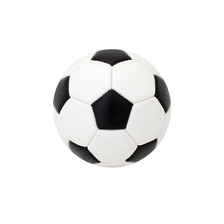

Top 5 Predictions:
1. soccer_ball: 89.90%
2. honeycomb: 7.14%
3. whistle: 0.61%
4. digital_clock: 0.27%
5. golf_ball: 0.20%


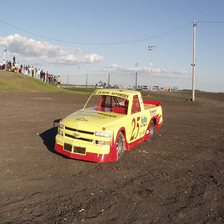

Top 5 Predictions:
1. racer: 80.54%
2. sports_car: 6.28%
3. pickup: 4.36%
4. tow_truck: 2.68%
5. car_wheel: 1.95%


In [6]:
ROOT = "https://data.heatonresearch.com/data/t81-558/images/"

classify_image(ROOT+"soccer_ball.jpg")
classify_image(ROOT+"race_truck.jpg")